# FRAUD DETECTION MODEL TRAINING with Random Forest

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score)
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Set matplotlib to display plots inline
%matplotlib inline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


# Load Dataset

In [2]:
print("📂 Loading dataset...")

# Pastikan file credit_card_transactions2.csv ada di folder yang sama
# Atau sesuaikan path-nya
df = pd.read_csv('../data/credit_card_transactions2.csv')
print("✓ Dataset loaded from '../data/credit_card_transactions2.csv'")

print(f"Total data: {len(df):,} rows")
print(f"Columns: {len(df.columns)} columns")
print(f"\nDataset Info:")
df.info()

📂 Loading dataset...
✓ Dataset loaded from '../data/credit_card_transactions2.csv'
Total data: 14,000 rows
Columns: 24 columns

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14000 non-null  int64  
 1   trans_date_trans_time  14000 non-null  object 
 2   cc_num                 14000 non-null  int64  
 3   merchant               14000 non-null  object 
 4   category               14000 non-null  object 
 5   amt                    14000 non-null  float64
 6   first                  14000 non-null  object 
 7   last                   14000 non-null  object 
 8   gender                 14000 non-null  object 
 9   street                 14000 non-null  object 
 10  city                   14000 non-null  object 
 11  state                  14000 non-null  object 
 12  zip             

# EXPLORATORY DATA ANALYSIS (EDA)


## 1. Dataset Overview

In [3]:
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n DATASET OVERVIEW:")
print(f"   Total Rows: {len(df):,}")
print(f"   Total Columns: {len(df.columns)}")
print(f"   Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")


EXPLORATORY DATA ANALYSIS (EDA)

 DATASET OVERVIEW:
   Total Rows: 14,000
   Total Columns: 24
   Memory Usage: 2.56 MB


## 2. Missing Values Check

In [4]:
print("\nMISSING VALUES CHECK:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("\nNo missing values detected!")
else:
    print("\nMissing values found:")
    print(missing[missing > 0])



MISSING VALUES CHECK:

Missing values found:
merch_zipcode    2094
dtype: int64


## 3. Duplicate Check

In [5]:
duplicates = df.duplicated().sum()
print(f"\nDUPLICATE ROWS: {duplicates:,}")
if duplicates > 0:
    print(f"   Removing {duplicates:,} duplicates...")
    df = df.drop_duplicates()


DUPLICATE ROWS: 0


## 4. Target Distribution

In [6]:
print("\nTARGET DISTRIBUTION (is_fraud):")
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)
print(f"\n   Not Fraud: {fraud_counts[0]:,} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"   Fraud:     {fraud_counts[1]:,} ({fraud_counts[1]/len(df)*100:.2f}%)")
print(f"   Balance Ratio: {fraud_counts[0]/fraud_counts[1]:.2f}:1")



TARGET DISTRIBUTION (is_fraud):
is_fraud
0    7000
1    7000
Name: count, dtype: int64

   Not Fraud: 7,000 (50.00%)
   Fraud:     7,000 (50.00%)
   Balance Ratio: 1.00:1


## 5. Statistical Summary

In [7]:
print("\nSTATISTICAL SUMMARY (Numerical Features):")
print(df[['amt']].describe())


STATISTICAL SUMMARY (Numerical Features):
                amt
count  14000.000000
mean     299.520382
std      373.829404
min        1.000000
25%       20.587500
50%       89.680000
75%      477.102500
max     6337.250000


# EDA VISUALIZATIONS

## Target Distribution

Setup Visualisasi Selesai. Lanjut ke cell berikutnya.

 Generating EDA Visualizations...


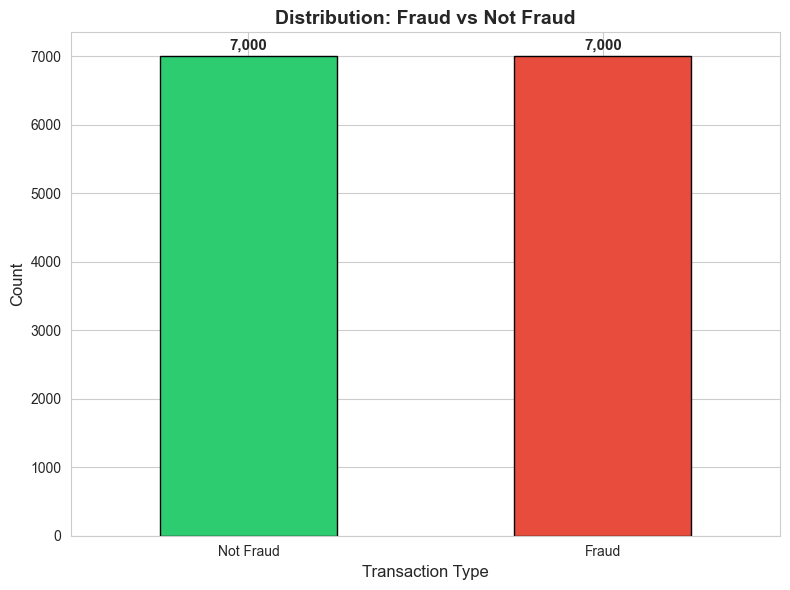

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Style
sns.set_style('whitegrid')
colors = ['#2ecc71', '#e74c3c']  # Hijau (Aman) & Merah (Fraud)

# Persiapan Data Awal (agar cell bawah tidak error)
fraud_counts = df['is_fraud'].value_counts()
print("Setup Visualisasi Selesai. Lanjut ke cell berikutnya.")

print("\n Generating EDA Visualizations...")

plt.figure(figsize=(8, 6)) # Ukuran disesuaikan untuk single plot

ax = fraud_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Distribution: Fraud vs Not Fraud', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'], rotation=0)

# Menambahkan label angka di atas batang
for i, v in enumerate(fraud_counts):
    plt.text(i, v + 100, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Amount Distribution by Fraud

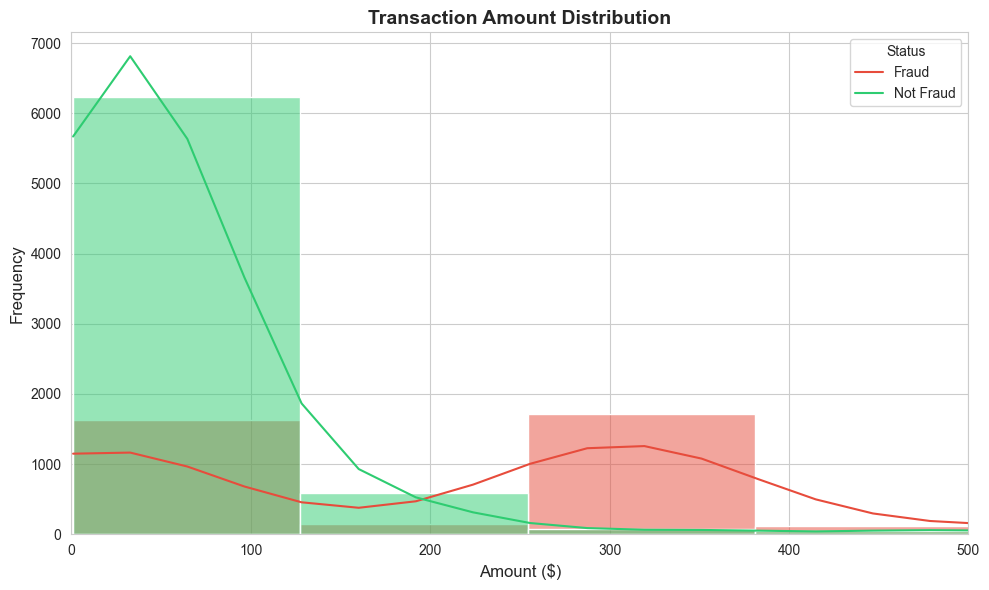

In [9]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='amt', hue='is_fraud', bins=50, kde=True, palette=colors)

plt.title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 500) # Fokus ke transaksi di bawah $500 biar grafik terbaca

plt.legend(title='Status', labels=['Fraud', 'Not Fraud'])
plt.tight_layout()
plt.show()

## Boxplot - Amount by Fraud

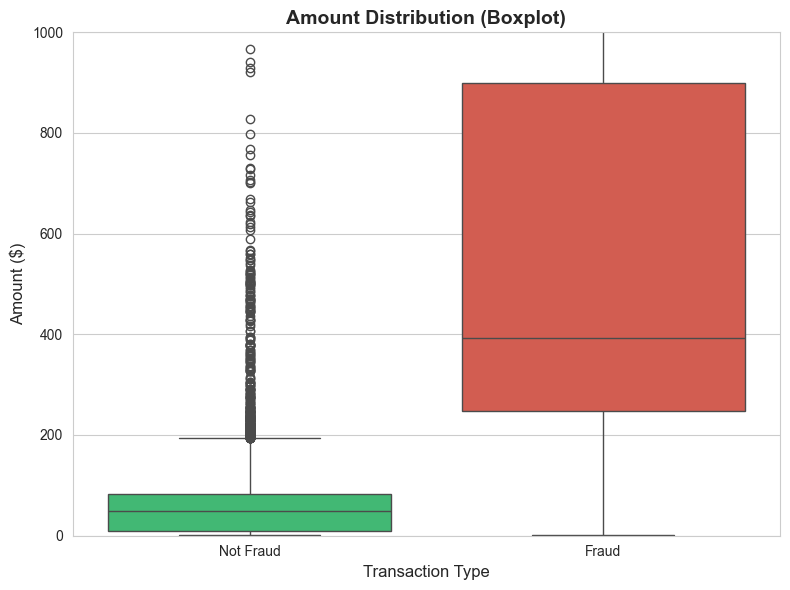

In [10]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_fraud', y='amt', palette=colors)

plt.title('Amount Distribution (Boxplot)', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.ylim(0, 1000) # Zoom in ke range 0-1000 dollar

plt.tight_layout()
plt.show()

## Top 10 Categories

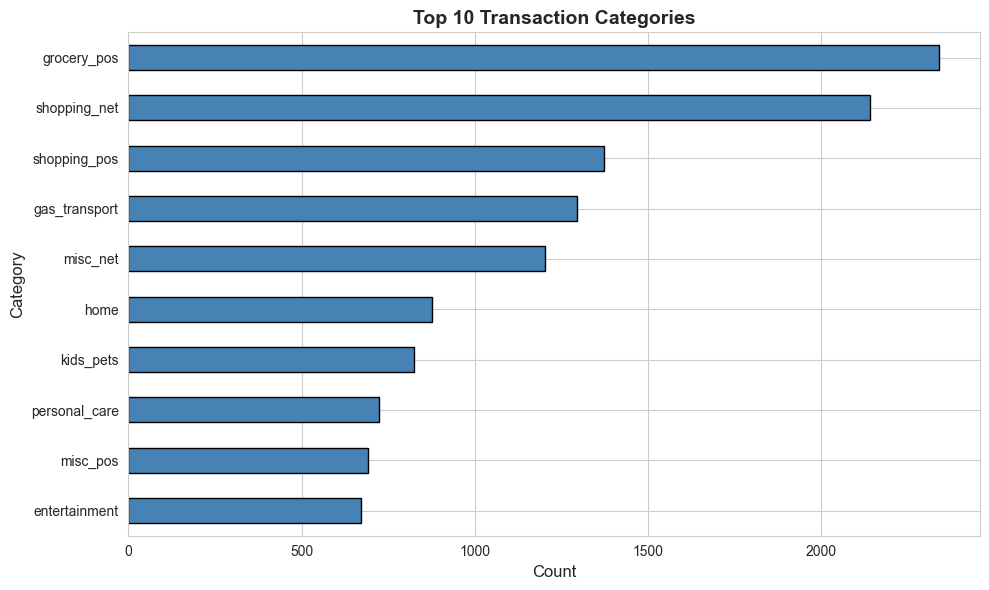

In [11]:
plt.figure(figsize=(10, 6))

top_categories = df['category'].value_counts().head(10).sort_values(ascending=True)
top_categories.plot(kind='barh', color='steelblue', edgecolor='black')

plt.title('Top 10 Transaction Categories', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

## Fraud Rate by Category

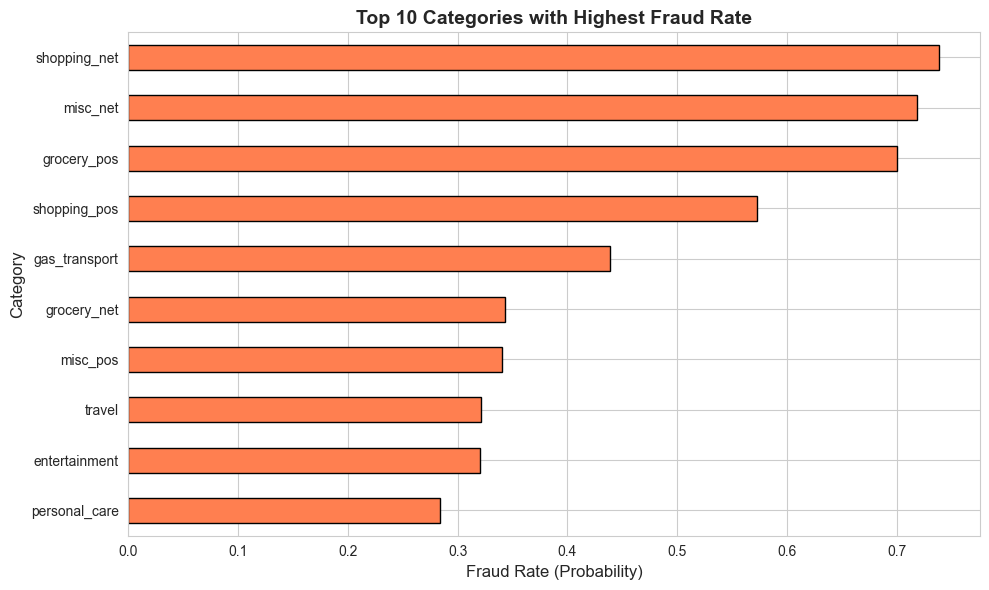

In [12]:
plt.figure(figsize=(10, 6))

# Menghitung rata-rata fraud per kategori
fraud_by_category = df.groupby('category')['is_fraud'].mean().sort_values(ascending=True).tail(10)

fraud_by_category.plot(kind='barh', color='coral', edgecolor='black')

plt.title('Top 10 Categories with Highest Fraud Rate', fontsize=14, fontweight='bold')
plt.xlabel('Fraud Rate (Probability)', fontsize=12)
plt.ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

## Gender Distribution

<Figure size 800x600 with 0 Axes>

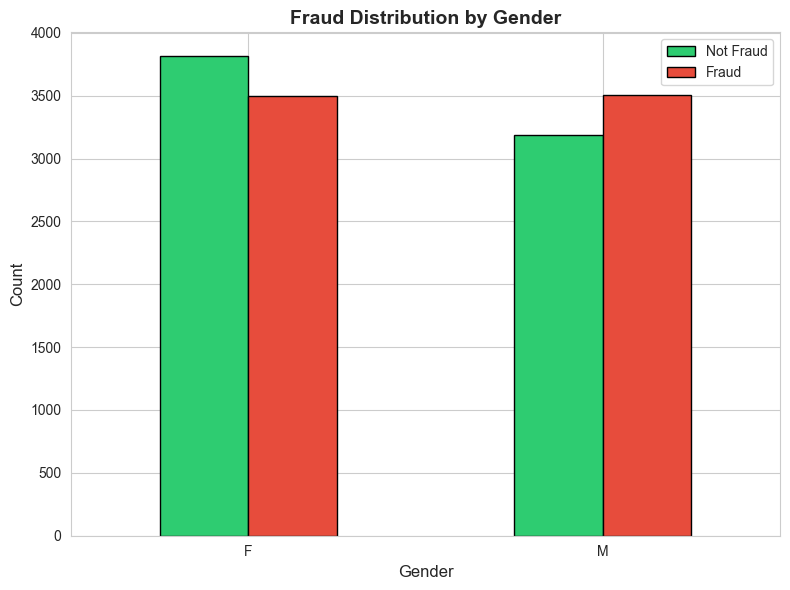

In [13]:
plt.figure(figsize=(8, 6))

gender_fraud = df.groupby(['gender', 'is_fraud']).size().unstack()
gender_fraud.plot(kind='bar', stacked=False, color=colors, figsize=(8,6), edgecolor='black')

plt.title('Fraud Distribution by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Not Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

## State Distribution (Top 10)

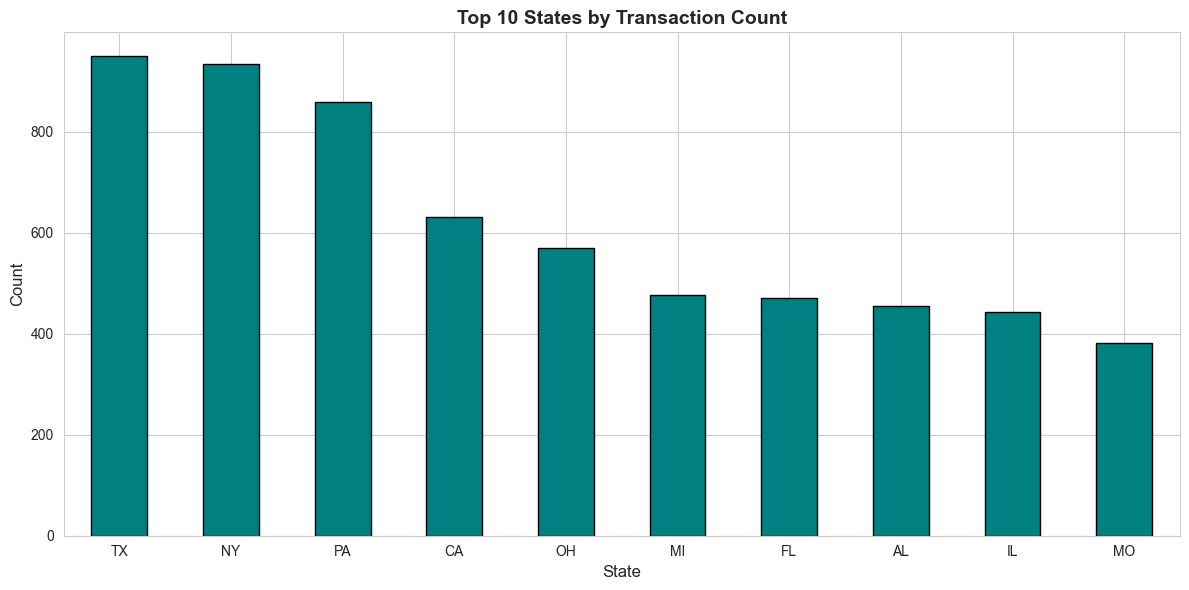

In [14]:
plt.figure(figsize=(12, 6))

top_states = df['state'].value_counts().head(10)
top_states.plot(kind='bar', color='teal', edgecolor='black')

plt.title('Top 10 States by Transaction Count', fontsize=14, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Amount Statistics

<Figure size 1000x600 with 0 Axes>

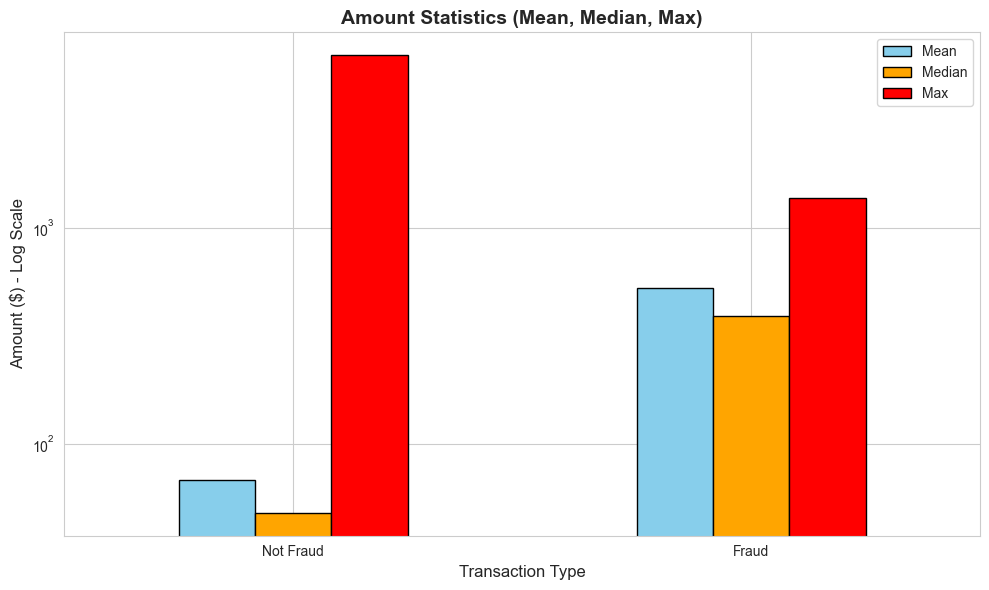

In [15]:
plt.figure(figsize=(10, 6))

amount_stats = df.groupby('is_fraud')['amt'].agg(['mean', 'median', 'max'])

# Pakai Log Scale biar 'max' yang besar tidak menutupi 'mean' yang kecil
amount_stats.plot(kind='bar', color=['skyblue', 'orange', 'red'], figsize=(10,6), edgecolor='black')

plt.title('Amount Statistics (Mean, Median, Max)', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Amount ($) - Log Scale', fontsize=12)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'], rotation=0)
plt.yscale('log') # Menggunakan skala logaritmik agar visualisasi lebih jelas
plt.legend(['Mean', 'Median', 'Max'])

plt.tight_layout()
plt.show()

## Correlation Preview

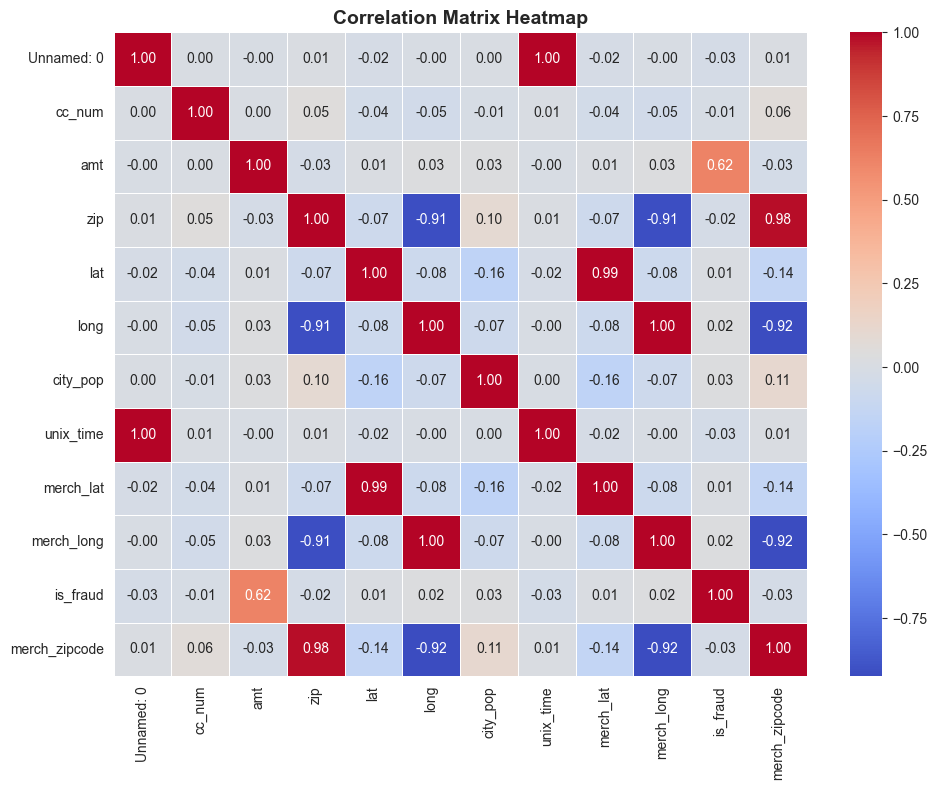

✅ EDA Visualizations Complete!



In [16]:
plt.figure(figsize=(10, 8))

# Pilih kolom numerik saja untuk korelasi
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

# Gambar Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ EDA Visualizations Complete!\n")

# FEATURE ENGINEERING

In [17]:
print("="*70)
print("🔧 FEATURE ENGINEERING")
print("="*70)

# Hitung umur dari DOB
df['dob'] = pd.to_datetime(df['dob'])
current_year = datetime.now().year
df['age'] = current_year - df['dob'].dt.year
print(f"✓ Feature 'age' created (range: {df['age'].min()}-{df['age'].max()})")

# Extract jam dari trans_date_trans_time
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
print(f"✓ Feature 'hour' created (range: {df['hour'].min()}-{df['hour'].max()})")

# Feature tambahan: deteksi pola weekend
df['is_weekend'] = df['trans_date_trans_time'].dt.dayofweek.isin([5, 6]).astype(int)
weekend_count = df['is_weekend'].sum()
print(f"✓ Feature 'is_weekend' created ({weekend_count:,} weekend transactions)")

# Feature tambahan: amount per hour ratio
df['amt_per_hour_ratio'] = df['amt'] / (df['hour'] + 1)
print(f"✓ Feature 'amt_per_hour_ratio' created")

# Drop kolom yang tidak relevan
drop_cols = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num',
             'unix_time', 'trans_date_trans_time', 'dob', 'merchant', 'job',
             'zip', 'lat', 'long', 'merch_lat', 'merch_long', 'merch_zipcode',
             'city_pop', 'city']

df = df.drop(columns=drop_cols, errors='ignore')
print(f"\n Final features: {df.columns.tolist()}")

🔧 FEATURE ENGINEERING
✓ Feature 'age' created (range: 21-102)
✓ Feature 'hour' created (range: 0-23)
✓ Feature 'is_weekend' created (4,677 weekend transactions)
✓ Feature 'amt_per_hour_ratio' created

 Final features: ['category', 'amt', 'gender', 'state', 'is_fraud', 'age', 'hour', 'is_weekend', 'amt_per_hour_ratio']


## Feature Correlation Analysis


Analyzing Feature Correlations...


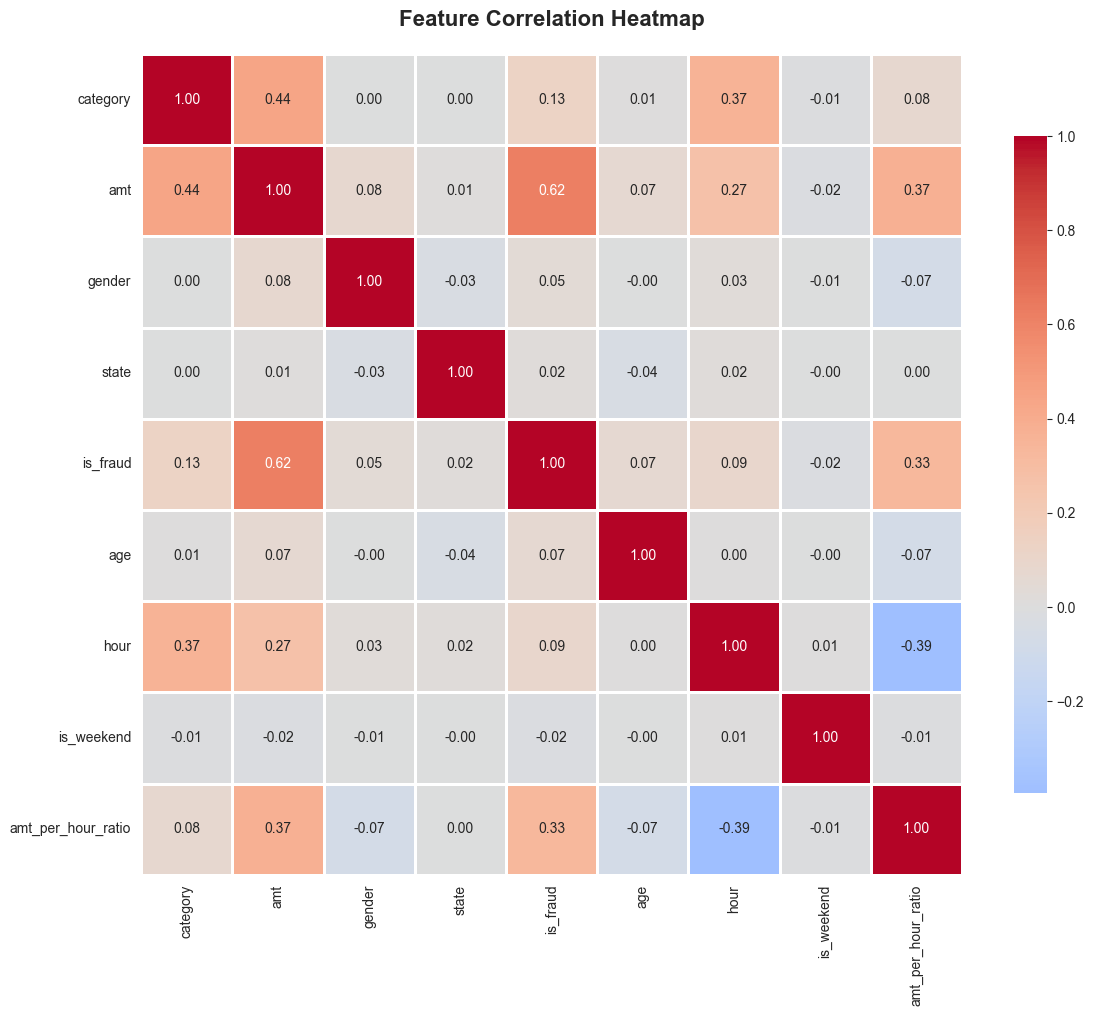

In [18]:
print("\nAnalyzing Feature Correlations...")

# Prepare numerical data for correlation
temp_df = df.copy()
categorical_cols = ['category', 'gender', 'state']

# Temporary encoding for correlation
for col in categorical_cols:
    if col in temp_df.columns:
        temp_df[col] = LabelEncoder().fit_transform(temp_df[col].astype(str))

# Correlation matrix
plt.figure(figsize=(12, 10)) # Increased figsize
correlation = temp_df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20) # Increased font size
plt.tight_layout()
plt.show()

In [19]:
# Feature correlation with target
print("\n🎯 Top Correlations with 'is_fraud':")
target_corr = correlation['is_fraud'].abs().sort_values(ascending=False)
print(target_corr.head(10))



🎯 Top Correlations with 'is_fraud':
is_fraud              1.000000
amt                   0.618721
amt_per_hour_ratio    0.331507
category              0.127692
hour                  0.087722
age                   0.067341
gender                0.045187
is_weekend            0.023473
state                 0.017526
Name: is_fraud, dtype: float64


# Preprocessing

In [20]:
print("\n" + "="*70)
print("⚙️ DATA PREPROCESSING")
print("="*70)

# Pisahkan fitur dan target
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Label Encoding untuk kolom kategorikal
categorical_cols = ['category', 'gender', 'state']
label_encoders = {}

for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"✓ Encoded '{col}' → {len(le.classes_)} unique values")

# Scaling untuk numerical features
numerical_cols = ['amt', 'age', 'hour', 'is_weekend', 'amt_per_hour_ratio']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print(f"\n✓ Scaled {len(numerical_cols)} numerical features")

print(f"\n✅ Total features for training: {X.shape[1]}")
print(f"✅ Feature names: {X.columns.tolist()}")


⚙️ DATA PREPROCESSING
✓ Encoded 'category' → 14 unique values
✓ Encoded 'gender' → 2 unique values
✓ Encoded 'state' → 51 unique values

✓ Scaled 5 numerical features

✅ Total features for training: 8
✅ Feature names: ['category', 'amt', 'gender', 'state', 'age', 'hour', 'is_weekend', 'amt_per_hour_ratio']


# Split Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n📊 Data Split Summary:")
print(f"   Training Set:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Testing Set:    {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Train Fraud:    {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"   Test Fraud:     {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.1f}%)")



📊 Data Split Summary:
   Training Set:   11,200 samples (80.0%)
   Testing Set:    2,800 samples (20.0%)
   Train Fraud:    5,600 (50.0%)
   Test Fraud:     1,400 (50.0%)


# Training Model (Random Forest)

In [22]:
# 1. Import library
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*70)
print("TRAINING & VALIDATION PROCESS")
print("="*70)

# 2. DEFINISIKAN MODEL DULU (Ini harus paling atas)
print("1. Menginisialisasi Model Random Forest...")
model = RandomForestClassifier(
    n_estimators=200,        # 200 decision trees
    max_depth=15,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,         # Reproducibility
    n_jobs=-1,               # Use all CPU cores
    verbose=0                # Matikan verbose biar output CV gak berantakan
)

# 3. LAKUKAN CROSS-VALIDATION (Validasi Model)
print("2. Melakukan Cross-Validation (5-Fold)...")
# Note: Scoring bisa diganti 'f1' atau 'recall' karena kasus Fraud
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"   ► Hasil per fold: {cv_scores}")
print(f"   ► Rata-rata Accuracy CV: {cv_scores.mean():.4f}")

if cv_scores.mean() > 0.90:
    print("   ✅ Model Robust & Stabil (Konsisten Tinggi)")
else:
    print("   ⚠️ Model kurang stabil, perlu tuning lagi.")

print("-" * 50)

# 4. TRAINING FINAL (Fit ke seluruh data training)
print("3. Final Training (Fitting model ke seluruh X_train)...")
model.fit(X_train, y_train)

print("\n✅ Training Complete! Model siap digunakan.")


TRAINING & VALIDATION PROCESS
1. Menginisialisasi Model Random Forest...
2. Melakukan Cross-Validation (5-Fold)...
   ► Hasil per fold: [0.97008929 0.97366071 0.96919643 0.96875    0.97321429]
   ► Rata-rata Accuracy CV: 0.9710
   ✅ Model Robust & Stabil (Konsisten Tinggi)
--------------------------------------------------
3. Final Training (Fitting model ke seluruh X_train)...

✅ Training Complete! Model siap digunakan.


# Model Evaluation


📈 MODEL EVALUATION

🔄 Performing Cross-Validation...
   Cross-validation Recall Scores: [0.96428571 0.97071429 0.96785714 0.97214286 0.96857143]
   Mean CV Recall: 0.9687 (+/- 0.0027)

🎯 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy  : 0.9721 (97.21%)
Precision : 0.9701 (97.01%) - Dari prediksi fraud, berapa yang benar
Recall    : 0.9743 (97.43%) - Dari fraud asli, berapa yang terdeteksi
F1-Score  : 0.9722 - Harmonic mean of Precision & Recall
ROC-AUC   : 0.9968 - Area Under ROC Curve
----------------------------------------------------------------------

🔍 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negative  (TN): 1,358 → Correctly predicted SAFE
False Positive (FP): 42 → False alarm (predicted FRAUD, actually SAFE)
False Negative (FN): 36 → MISSED FRAUD (predicted SAFE, actually FRAUD) ⚠️
True Positive  (TP): 1,364 → Correctly predicted FRAUD
------------------------------------

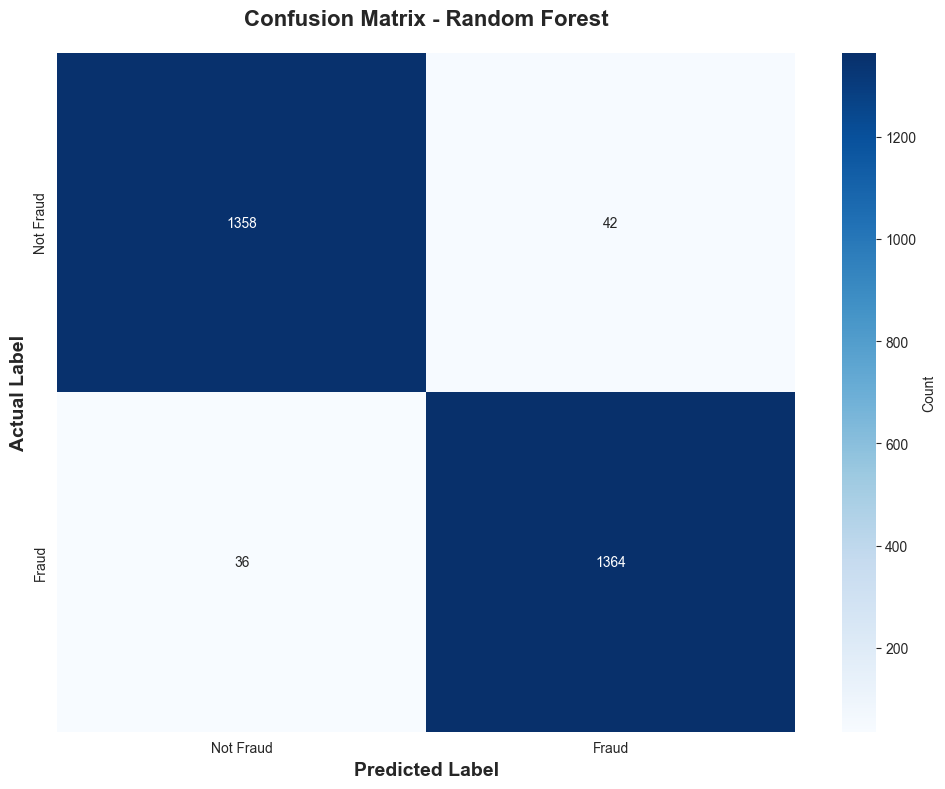

In [23]:
print("\n" + "="*70)
print("📈 MODEL EVALUATION")
print("="*70)

# Cross-validation setup
print("\n🔄 Performing Cross-Validation...")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='recall', n_jobs=-1)
print(f"   Cross-validation Recall Scores: {cv_scores}")
print(f"   Mean CV Recall: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🎯 PERFORMANCE METRICS:")
print("-" * 70)
print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision : {precision:.4f} ({precision*100:.2f}%) - Dari prediksi fraud, berapa yang benar")
print(f"Recall    : {recall:.4f} ({recall*100:.2f}%) - Dari fraud asli, berapa yang terdeteksi")
print(f"F1-Score  : {f1:.4f} - Harmonic mean of Precision & Recall")
print(f"ROC-AUC   : {roc_auc:.4f} - Area Under ROC Curve")
print("-" * 70)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🔍 CONFUSION MATRIX:")
print("-" * 70)
print(f"True Negative  (TN): {cm[0][0]:,} → Correctly predicted SAFE")
print(f"False Positive (FP): {cm[0][1]:,} → False alarm (predicted FRAUD, actually SAFE)")
print(f"False Negative (FN): {cm[1][0]:,} → MISSED FRAUD (predicted SAFE, actually FRAUD) ⚠️")
print(f"True Positive  (TP): {cm[1][1]:,} → Correctly predicted FRAUD")
print("-" * 70)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Label', fontsize=14, fontweight='bold') 
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix - Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


# Feature Importance Analysis


📊 FEATURE IMPORTANCE ANALYSIS
----------------------------------------------------------------------

Top 10 Most Important Features:
           feature  importance
               amt    0.455320
amt_per_hour_ratio    0.229114
              hour    0.184917
          category    0.086849
               age    0.024568
             state    0.012826
            gender    0.004168
        is_weekend    0.002239


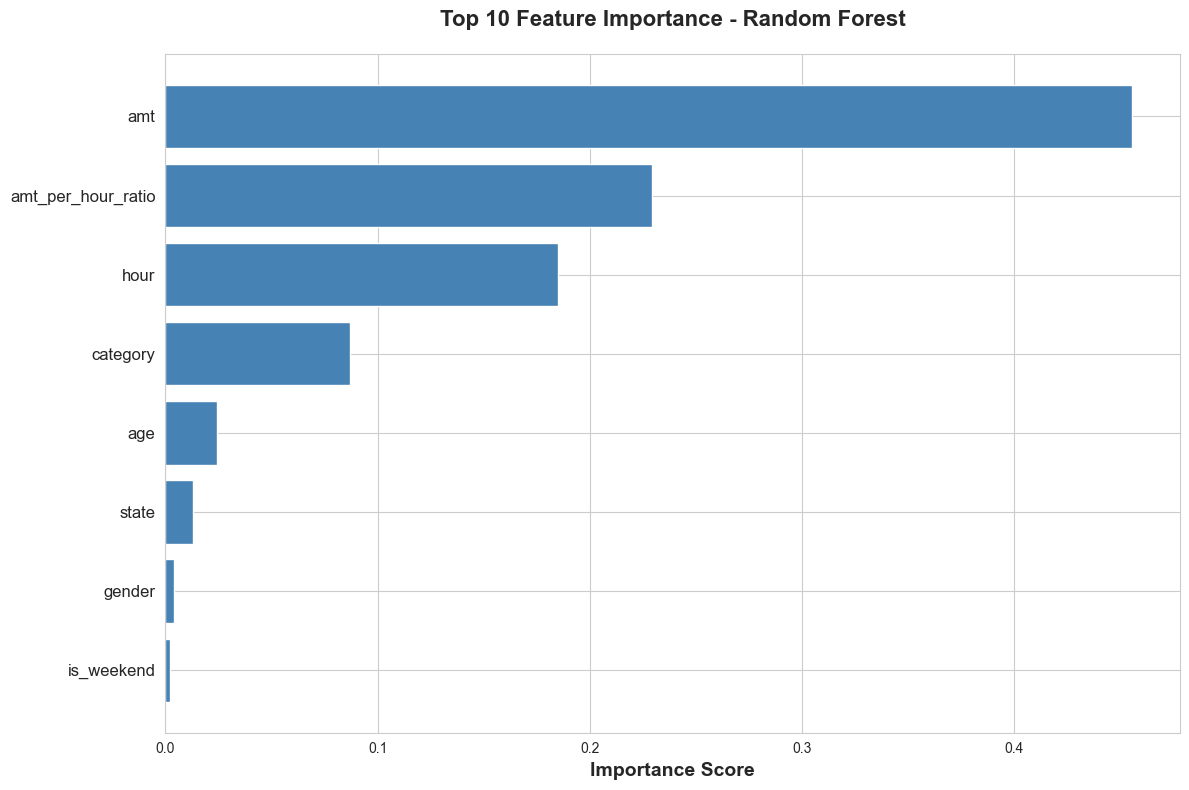

In [24]:
print("\n📊 FEATURE IMPORTANCE ANALYSIS")
print("-" * 70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize Feature Importance
plt.figure(figsize=(12, 8)) # Increased figsize
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=12) # Increased font size
plt.xlabel('Importance Score', fontsize=14, fontweight='bold') # Increased font size
plt.title('Top 10 Feature Importance - Random Forest', fontsize=16, fontweight='bold', pad=20) # Increased font size
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save Model

In [27]:
print("\n" + "="*70)
print(" SAVING MODEL & PREPROCESSORS")
print("="*70)

model_artifacts = {
    'model': model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': X.columns.tolist(),
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'performance': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
}

import os

output_dir = os.path.join(os.getcwd(), '..', 'models')
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, 'fraud_detection_model.pkl')

# 4. Simpan model
with open(model_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"Model successfully saved to: {os.path.abspath(model_path)}")

# 5. Cek ukuran file
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / 1024**2
    print(f"File size: {file_size:.2f} MB")

print("\n" + "="*70)
print(" TRAINING PIPELINE COMPLETE!")
print("="*70)
print("\n NEXT STEPS:")
print(f"1.  File '{model_path}' sudah tersimpan")
print("2.  Jalankan: streamlit run app.py")
print("3.  Test the fraud detection system!")
print("="*70)



 SAVING MODEL & PREPROCESSORS
Model successfully saved to: D:\discord\machine-learning2\fraud-detection\models\fraud_detection_model.pkl
File size: 10.99 MB

 TRAINING PIPELINE COMPLETE!

 NEXT STEPS:
1.  File 'D:\discord\machine-learning2\fraud-detection\notebook\..\models\fraud_detection_model.pkl' sudah tersimpan
2.  Jalankan: streamlit run app.py
3.  Test the fraud detection system!


# Test Prediction (Manual)

In [26]:
print("\n" + "="*70)
print(" MANUAL PREDICTION TEST")
print("="*70)

# Test Case 1: Suspicious Transaction
print("\n TEST CASE 1: Suspicious Transaction")
print("-" * 70)

test_input_1 = pd.DataFrame({
    'category': [label_encoders['category'].transform(['gas_transport'])[0]],
    'amt': [1500.0],
    'gender': [label_encoders['gender'].transform(['M'])[0]],
    'state': [label_encoders['state'].transform(['TX'])[0]],
    'age': [25],
    'hour': [3],
    'is_weekend': [1],
    'amt_per_hour_ratio': [1500.0 / 4]
})

test_input_1 = test_input_1[X.columns]
test_input_1[numerical_cols] = scaler.transform(test_input_1[numerical_cols])

pred_1 = model.predict(test_input_1)[0]
prob_1 = model.predict_proba(test_input_1)[0]

print(f"Input: $1,500 transaction at 3 AM on weekend (Gas/Transport)")
print(f"Result: {'FRAUD' if pred_1 == 1 else 'SAFE'}")
print(f"Confidence: {prob_1[pred_1]*100:.2f}%")
print(f"Probability → Safe: {prob_1[0]*100:.1f}% | Fraud: {prob_1[1]*100:.1f}%")

# Test Case 2: Normal Transaction
print("\nTEST CASE 2: Normal Transaction")
print("-" * 70)

test_input_2 = pd.DataFrame({
    'category': [label_encoders['category'].transform(['grocery_pos'])[0]],
    'amt': [50.0],
    'gender': [label_encoders['gender'].transform(['F'])[0]],
    'state': [label_encoders['state'].transform(['CA'])[0]],
    'age': [35],
    'hour': [14],
    'is_weekend': [0],
    'amt_per_hour_ratio': [50.0 / 15]
})

test_input_2 = test_input_2[X.columns]
test_input_2[numerical_cols] = scaler.transform(test_input_2[numerical_cols])

pred_2 = model.predict(test_input_2)[0]
prob_2 = model.predict_proba(test_input_2)[0]

print(f"Input: $50 transaction at 2 PM on weekday (Grocery)")
print(f"Result: {'FRAUD' if pred_2 == 1 else 'SAFE'}")
print(f"Confidence: {prob_2[pred_2]*100:.2f}%")
print(f"Probability → Safe: {prob_2[0]*100:.1f}% | Fraud: {prob_2[1]*100:.1f}%")

print("\nManual testing complete!")
print("="*70)



 MANUAL PREDICTION TEST

 TEST CASE 1: Suspicious Transaction
----------------------------------------------------------------------
Input: $1,500 transaction at 3 AM on weekend (Gas/Transport)
Result: FRAUD
Confidence: 80.36%
Probability → Safe: 19.6% | Fraud: 80.4%

TEST CASE 2: Normal Transaction
----------------------------------------------------------------------
Input: $50 transaction at 2 PM on weekday (Grocery)
Result: SAFE
Confidence: 99.17%
Probability → Safe: 99.2% | Fraud: 0.8%

Manual testing complete!
